# Retinal pyramid

## Initialization parameters

In [169]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 1.61803
base_levels = 2 #downsampling/upsampling factor

N_batch = 4 #number of images 
pattern = 'i05june05_static_street_boston_*.jpeg'

## Libraries

In [170]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
import os

In [172]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [173]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-03-06T16:57:39+01:00

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
torch 1.0.1.post2
POLO not installed

compiler   : GCC 8.3.0
system     : Linux
release    : 4.19.0-5-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit
host name  : port-dauce
Git hash   : debcc3368f511e2cc2b61b09592acea81bf5cc43
Git repo   : https://github.com/bicv/POLO
Git branch : master


## Loading an image

In [174]:
from PIL import Image

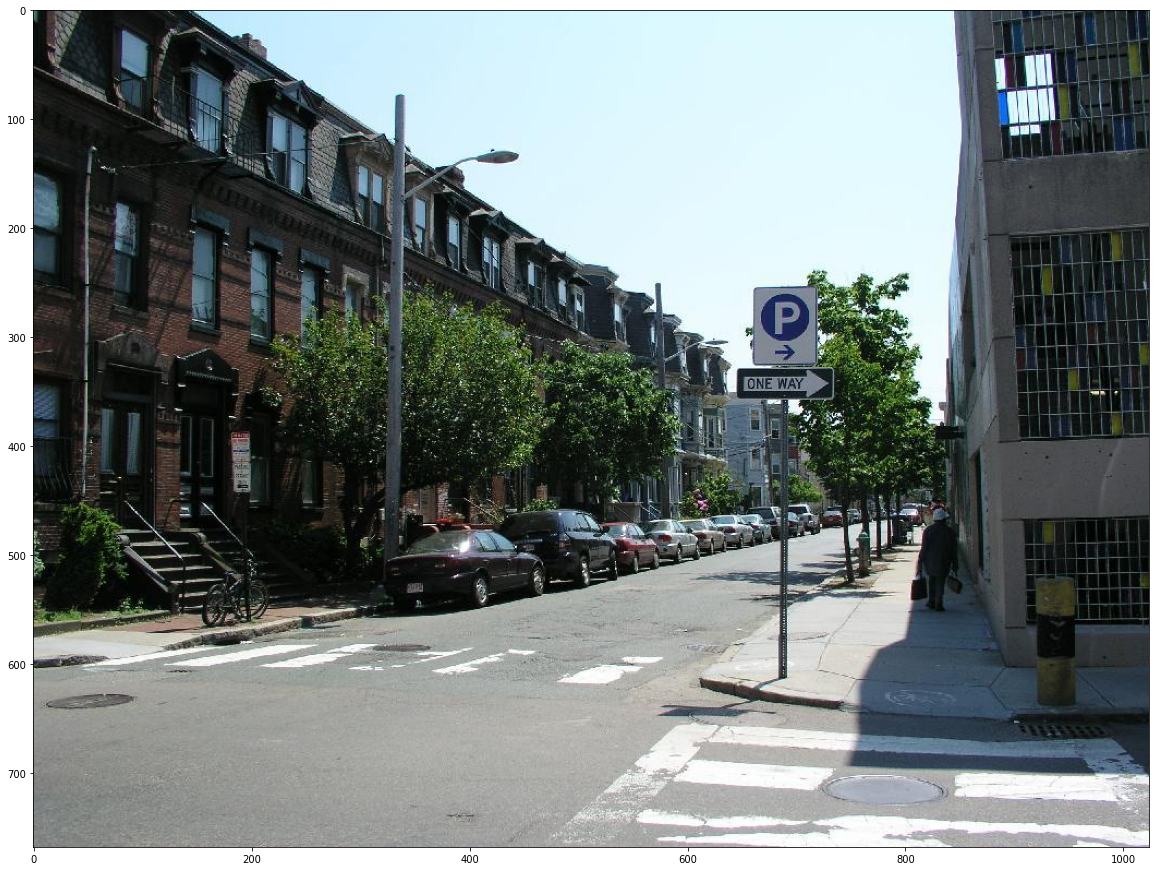

In [175]:
img_orig = Image.open('../data/i05june05_static_street_boston_p1010764.jpeg')

im_color_npy = np.asarray(img_orig)
N_X, N_Y, _ = im_color_npy.shape


fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(im_color_npy)

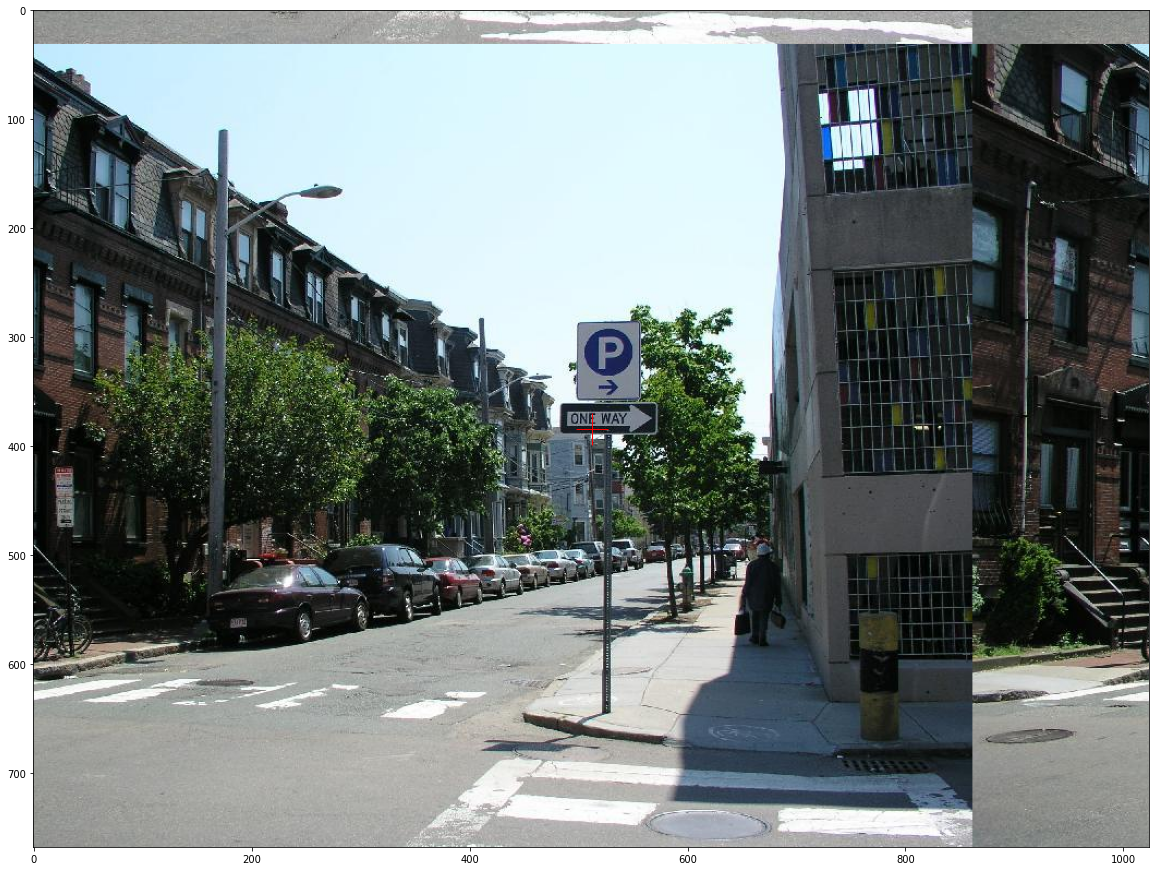

In [176]:
im_color_npy = np.roll(im_color_npy, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
im_color_npy = np.roll(im_color_npy, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom


fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(im_color_npy)
ax.plot(N_Y//2, N_X//2, 'r+', ms=32);


In [177]:
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #converting to a tensor format, image's size stored in img_tens.shape[-2:]

Tensor shape= torch.Size([1, 3, 768, 1024])


# Using torch to build up a Laplacian pyramid


https://www.cs.tau.ac.il/~dcor/Graphics/Exercises/burt83laplacian.pdf

## Down-sampling recursively 

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate


In [178]:
from torch.nn.functional import interpolate 

In [179]:
#%%timeit
img_down = interpolate(img_tens, scale_factor=1/2, mode=mode) 
print(img_down.shape)

torch.Size([1, 3, 384, 512])


torch.Size([384, 512, 3])


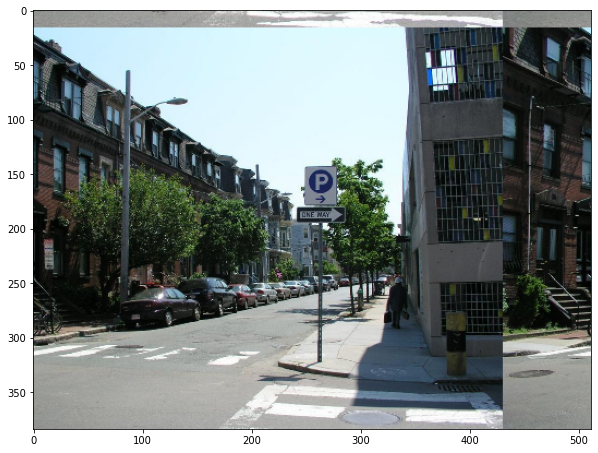

In [180]:
img_aff = img_down.permute(0,2,3,1)[0,:,:,:]
print(img_aff.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_aff.numpy().astype('uint'))
#ax.plot(N_Y//2, N_X//2, 'r+', ms=32);


In [181]:
img_down = img_tens.clone() 
n_levels = 0
while max(img_down.shape[-2:]) > width : # until obtaining sides inferior to width (cf cropped image at each step) 
    n_levels += 1 
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels) #each iteration reduces the image's size by a factor defined by base_levels
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) # downsampling 1/base_levels (bilinear mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 3, 768, 1024]) , n_levels= 1
Tensor shape= torch.Size([1, 3, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 3, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 3, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 3, 48, 64]) , n_levels= 5
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


In [182]:
#Computing number of iterations to downsample the image to a size < width
n_levels = int(np.log(np.max(im_color_npy.shape)/width)/np.log(base_levels)) + 1 
print('Computed n_levels=', n_levels)

Computed n_levels= 6


Applying on the central crop of $32\times32$:

In [183]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape # tensor of the images  (dimension 4)
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #computing the number of iterations cf:downsampling
    
    img_crop = torch.zeros((N_batch, n_levels, 3, width, width)) #creating the tensor to store the cropped images while pyramiding

    img_down = img_tens.clone()
    for i_level in range(n_levels-1): #each iteration -> residual_image = image - downsampled_cloned_image_reshaped_to_the_right_size 
        img_residual = img_down.clone()
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) #downsampling
        img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)  #upsizing in order to substract

        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_residual.shape)
        h_res, w_res = img_residual.shape[-2:] #at each iteration the residual image size is reduced of a factor 1/base_levels (img_down the image downsampled at the previous iteration)

        img_crop[:, i_level, :, :, :] = img_residual[:, :, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)] #the central crop of residual image stored in tensor img_crop

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, :, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down #[0, :, :, :]
    if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels) #print image's dimensions after downsampling, condition max(img_down.shape[-2:])<=width satisfied
    return img_crop 

img_crop = cropped_pyramid(img_tens, verbose=True)

Tensor shape= torch.Size([1, 3, 384, 512]) , shape= torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 192, 256]) , shape= torch.Size([1, 3, 384, 512])
Tensor shape= torch.Size([1, 3, 96, 128]) , shape= torch.Size([1, 3, 192, 256])
Tensor shape= torch.Size([1, 3, 48, 64]) , shape= torch.Size([1, 3, 96, 128])
Tensor shape= torch.Size([1, 3, 24, 32]) , shape= torch.Size([1, 3, 48, 64])
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


In [184]:
img_down.shape

torch.Size([1, 3, 24, 32])

Tensor shape= torch.Size([1, 6, 3, 32, 32])


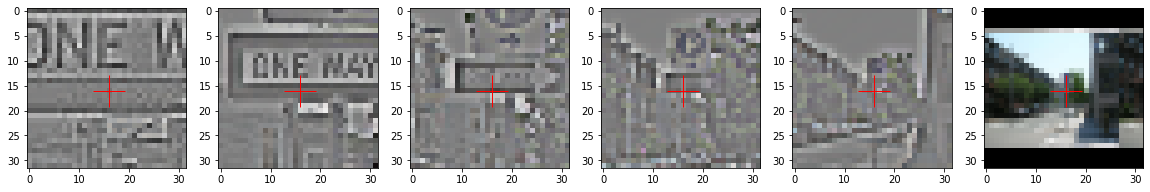

In [185]:
#displaying central crops from successive residual images
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_crop.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)  

In [186]:
img_crop.shape

torch.Size([1, 6, 3, 32, 32])

# Reconstruction

## Inverse pyramid from the coefficients

In [187]:
def inverse_pyramid(img_crop, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, :, 
                (h_res//2-width//2):(h_res//2+width//2), 
                (w_res//2-width//2):(w_res//2+width//2)] += img_crop[:, i_level, :, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

img_rec = inverse_pyramid(img_crop)

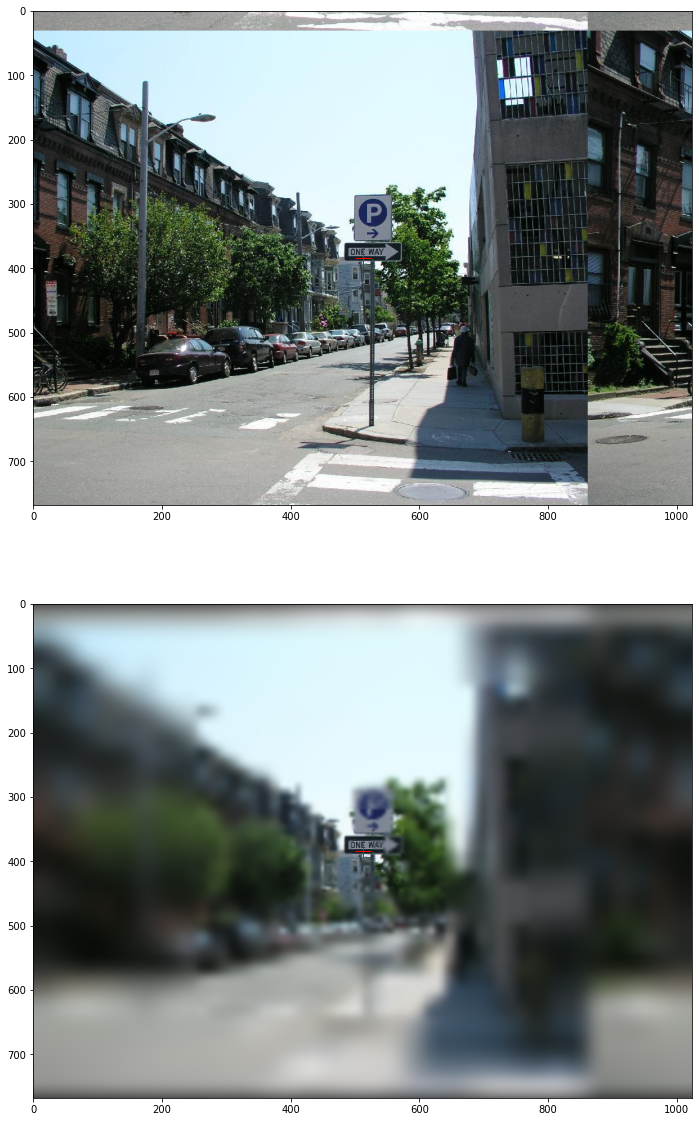

In [196]:
#Plotting reconstructed image
fig, axs = plt.subplots(2, 1, figsize=(20,20))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

# Optimizing the reconstruction

## Defining a dataloader

In [189]:
def get_dataloader(K, N_batch, pattern=pattern, 
                   ds=ds, saccade_radius=.15, verbose=False):
    from glob import glob
    imgs = []
    for fname in glob(os.path.join('../data', pattern)):
        img_orig = imread(fname)
        if ds>1: img_orig = img_orig[::ds, ::ds]
        from SLIP import Image
        pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True}
        im = Image(pe)
        imgs.append(img_orig)
                          
    N_imgs = len(imgs)
    if verbose: print('N_imgs ', N_imgs )
    N_X, N_Y = img_orig.shape
    width = K.shape[0]
    #n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1

    target = torch.zeros((N_batch, 1, N_X, N_Y))
    for i in range(N_batch):
        # generate random saccades
        target_ = imgs[int(N_imgs*np.random.rand())].copy()
        sacc_x, sacc_y = np.int(saccade_radius*N_X*np.random.rand()), np.int(saccade_radius*N_Y*np.random.rand())
        if verbose: print('sacc_x, sacc_y ', sacc_x, sacc_y )
        target_ = np.roll(target_, sacc_y, axis=1)
        target_ = np.roll(target_, sacc_x, axis=0) 
        target[i, :, :, :] = torch.from_numpy(target_[None, :, :])

    if verbose: print(target.shape)
    img_crop = cropped_pyramid(target, verbose=verbose)
    if verbose: print(img_crop.shape)
    out = torch.tensordot(img_crop, K, dims=2)

    from torch.utils.data import TensorDataset, DataLoader
    dataloader = DataLoader(TensorDataset(target, out), batch_size=N_batch, shuffle=False, drop_last=False)
    return dataloader

dataloader = get_dataloader(K, N_batch, verbose=True)

NameError: name 'K' is not defined

## Validating the test set

In [ ]:
test_dataloader = get_dataloader(K, N_batch, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)

In [ ]:
img_rec = inverse_pyramid(out, K)
print('img_rec.shape', img_rec.shape)

In [ ]:
N_batch = 4

In [ ]:
for i_batch in range(N_batch): #applying the pyramid and reconstruction to a batch of images
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for ax, img in zip(axs, [target[i_batch, 0, :, :], img_rec[i_batch, 0, :, :]]):
        ax.imshow(img.numpy(), cmap='gray')
        ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);
